In [258]:
import os, sys, time, resource, re, gc, shutil
import operator
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *


import statsmodels.formula.api as sm, statsmodels.stats.api as sms


from run_id import run_id

run_id = 662

runstat = RunStats.objects.get(pk=run_id)
topics = DynamicTopic.objects.filter(run_id=run_id)

In [16]:
tsums = topics.aggregate(
    ip_score=Sum('ipcc_score'),
    score=Sum('ipcc_time_score')
)
tsums

topics.update(
    ipcc_share=F('ipcc_score')/tsums['ip_score'],
    share=F('ipcc_time_score')/tsums['score']
)

100

In [3]:
def calculate_deviations(df):
    df['deviation'] = df['ipcc_share'] - df['share']
    df['abs_md'] = abs(df['deviation'])

    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    df['representation'] = df['ipcc_share'] / df['share']  
    
    df_disp = {'MD':md,'Rae':rae,'L-H':lh}
    return [df,df_disp]


In [113]:



df = pd.DataFrame.from_dict(
    list(topics.values(
        'title',
        'score',
        'ipcc_coverage',
        'share',
        'ipcc_score',
        'ipcc_share',
        'ipcc_time_score',
        'primary_wg'
    ))
)

df, df_disp  = calculate_deviations(df)


df.sort_values('representation').head()

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation
53,0.029822,6.996709,0.000926,234.618406,3,668.346077,0.004727,"{adsorpt, adsorb, capac}",-0.003801,0.003801,0.195844
38,0.039887,10.607514,0.001404,265.938777,2,385.865575,0.005358,"{root, respir, fine}",-0.003955,0.003955,0.261946
70,0.040632,24.862808,0.003290,611.903042,1,1298.677539,0.012328,"{process, captur, reaction}",-0.009039,0.009039,0.266838
54,0.041303,10.294637,0.001362,249.246622,3,492.612029,0.005022,"{wast, landfil, compost}",-0.003660,0.003660,0.271245
21,0.044705,20.371524,0.002695,455.684960,2,683.251724,0.009181,"{sediment, deposit, eros}",-0.006486,0.006486,0.293588


In [5]:
df.sort_values('representation').tail()

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,score,share,title,deviation,abs_md,representation
22,0.293851,189.843534,0.025119,646.052698,911.704124,0.013016,"{simul, model, observ}",0.012102,0.012102,1.929778
44,0.300512,103.849334,0.013741,345.574858,438.025787,0.006963,"{ozon, stratospher, tropospher}",0.006778,0.006778,1.973518
60,0.305924,155.382957,0.020559,507.913964,778.731911,0.010233,"{scenario, futur, use}",0.010326,0.010326,2.009059
47,0.321221,129.810138,0.017176,404.114124,763.265479,0.008142,"{adapt, vulner, capac}",0.009034,0.009034,2.109522
27,0.365669,178.319801,0.023594,487.653665,678.414988,0.009825,"{aerosol, cloud, radiat}",0.013769,0.013769,2.401417


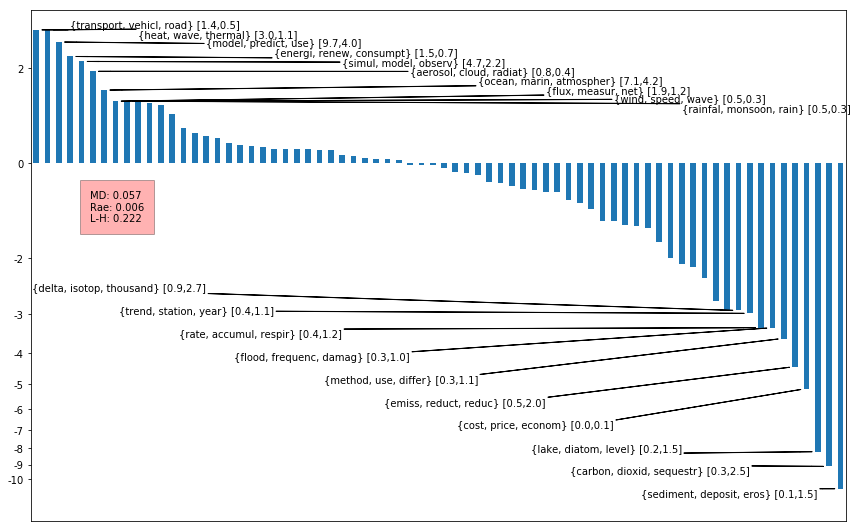

In [14]:

from matplotlib import ticker


plt.rcParams["figure.figsize"] = [12,7.5]

def plot_representation(df, ax, nts=5, xspace=3,yspace = 0.15, fmin=None, fmax=None):
    
    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    pdf = df.sort_values('representation',ascending=False).reset_index('title')

    pdf = pdf[pdf['share'] > 0.001]

    pdf['lrep'] = np.log(pdf['representation'])
    #pdf['lrep'] = pdf['representation']
    pdf.set_index('title')['lrep'].plot(kind="bar",ax=ax)

    i = 0

    rmax = pdf['lrep'].max()
    if fmax:
        rmax = fmax
    rmin = pdf['lrep'].min()
    if fmin:
        rmin = -fmin
    
    for index, row in pdf.head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(-0.5+i,row['lrep']),
            xytext=((xspace-3)*-1+i*xspace,rmax-rmax*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="left",
            va="bottom"
        )

    i = 0
    for index, row in pdf.sort_values('representation').head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(len(pdf)-0.5-i,row['lrep']),
            xytext=(len(pdf)+xspace-3-i*xspace,rmin-rmin*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="right",
            va="top"
        )
        
    #ax.set_yscale('log')
    
    
    if rmin > -1:
        rmin = -1
    if np.exp(rmax) < 2:
        rmax = np.log(2.1)
    
    lmin = int(1/np.exp(rmin)//1)*-1
    lmax = int(np.exp(rmax)//1)
    


    ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
    yticks = []
    for x in ytick_labels:
        if x < 0:
            y = np.log(-1/x)
        elif x==0:
            y = 0
        else:
            y = np.log(x)
        yticks.append(y)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        
    rmax = pdf['lrep'].max()
    rmin = pdf['lrep'].min()
    
    ax.text(
        len(pdf)*0.066,-0.2,
        "MD: {:.3f}\nRae: {:.3f}\nL-H: {:.3f}".format(md,rae,lh),
        va="top",
        ha="left",
        bbox={'facecolor':'red', 'alpha':0.3,'pad':10}
   )

    #ax.text(1,-1*0.2,"MD: {:.3f}".format(md))   
    #ax.text(1,-1*0.4,"Rae: {:.3f}".format(rae))   
    #ax.text(1,-1*0.6,"L-H: {:.3f}".format(lh))   
    
    ax.get_xaxis().set_visible(False)#.set_ticks([])
    
    ax.set_ylim((rmin+rmin*0.1,rmax+rmax*0.15))

fig, ax = plt.subplots()
plot_representation(df,ax,nts=10,xspace=6,yspace=0.07)
plt.tight_layout()
plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.png'.format(run_id),bbox_inches='tight')
plt.show()

In [7]:
rmin = -1.5
rmax = 1
lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)

ytick_labels = [i for i in range(lmin,lmax) if i not in [-1,1]]
print(ytick_labels)
yticks = []
for x in ytick_labels:
    if x < 0:
        x = np.log(-1/x)
    elif x==0:
        x = 0
    else:
        x = np.log(x)
    yticks.append(x)
#yticks = [np.log(x) if x!=0 else 0 for x in ytick_labels ]
print(yticks)

[-4, -3, -2, 0]
[-1.3862943611198906, -1.0986122886681098, -0.69314718055994529, 0]


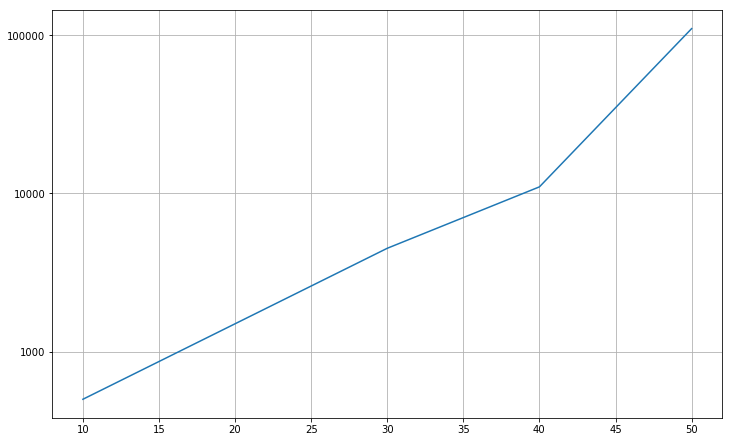

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

a = np.array([500, 1500, 4500, 11000, 110000])
b = np.array([10, 20, 30, 40, 50])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_yscale('symlog')

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

plt.plot(b, a)
plt.grid(True)

plt.show()

In [9]:
plt.rcParams["figure.figsize"] = [16,12]

stat = RunStats.objects.get(pk=run_id)

fig = plt.figure()


disp = pd.DataFrame(columns=['AR','MD','Rae','L-H'])
#fig, axs = plt.subplots(2,3,sharey=True)

for i, tp in enumerate(stat.periods.filter(n__lt=6)):
    if i == 0:
        ax = fig.add_subplot(2,3,i+1)
        ax1 = ax
    else:
        ax = fig.add_subplot(2,3,i+1,sharey=ax1)
    print(tp)
    tdts = TimeDTopic.objects.filter(dtopic__run_id=run_id,period=tp)
    
    df = pd.DataFrame.from_dict(
        list(tdts.values(
            'dtopic__title',
            'score',
            'share',
            'ipcc_score',
            'ipcc_share',
            #'ipcc_time_score'
        ))
    )
    
    df = df.rename(columns={'dtopic__title':'title'})
    
    df, df_disp  = calculate_deviations(df)
    df_disp['AR'] = tp.title   
    disp = disp.append(pd.DataFrame.from_dict([df_disp]))

    plot_representation(df, ax, 2.3,1)
    
    ax.set_title(tp.title)
    
    if tp.title=="AR5":
        ax = fig.add_subplot(2,3,6)
        
        disp = disp.set_index('AR')
        
        disp.plot(ax=ax)
        
        ax.set_title("Disproportionality")
    
    
    
    #plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_{}.png'.format(run_id,tp.title),bbox_inches='tight')
    #plt.show()

plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_ARS.png'.format(run_id),bbox_inches='tight')
plt.show()

disp.head()

AR1


TypeError: cannot do slice indexing on <class 'pandas.indexes.numeric.Int64Index'> with these indexers [2.3] of <class 'float'>

In [151]:
tds = topics.filter(timedtopic__period__n__lt=6).values(
    'title','timedtopic__period__title','timedtopic__period__n','timedtopic__score','score'
).order_by('id','timedtopic__period__n')

tdf = pd.DataFrame.from_dict(list(tds))

#tdf['ys'] = tdf[]

tdf['share'] = tdf['timedtopic__score'] / tdf['score']

tdf['ys'] = tdf['timedtopic__period__n'] * tdf['share']


tdf.head(12)
#tdf.groupby('')

,score,timedtopic__period__n,timedtopic__period__title,timedtopic__score,title,share,ys
0,549.140042,1,AR1,0.000000,"{industri, sector, intens}",0.000000,0.000000
1,549.140042,2,AR2,7.875215,"{industri, sector, intens}",0.014341,0.028682
2,549.140042,3,AR3,19.710819,"{industri, sector, intens}",0.035894,0.107682
3,549.140042,4,AR4,45.982418,"{industri, sector, intens}",0.083735,0.334941
4,549.140042,5,AR5,131.261191,"{industri, sector, intens}",0.239030,1.195152
5,849.147223,1,AR1,1.544717,"{surfac, layer, atmospher}",0.001819,0.001819
6,849.147223,2,AR2,25.276148,"{surfac, layer, atmospher}",0.029767,0.059533
7,849.147223,3,AR3,70.898813,"{surfac, layer, atmospher}",0.083494,0.250482
8,849.147223,4,AR4,150.006147,"{surfac, layer, atmospher}",0.176655,0.706620
9,849.147223,5,AR5,306.147135,"{surfac, layer, atmospher}",0.360535,1.802674


In [35]:
means = tdf.groupby('title')['ys'].mean()

means = pd.DataFrame({'ys' : tdf.groupby('title')['ys'].mean()}).reset_index()

means.sort_values('ys',ascending=False).head()

,title,ys
2,"{adsorpt, adsorb, capac}",0.936479
7,"{build, construct, design}",0.920227
92,"{urban, citi, plan}",0.917996
32,"{food, consumpt, household}",0.916226
45,"{industri, sector, intens}",0.904742


In [54]:
for name, group in tdf.groupby('title'):
    l = []
    for index, y in group.iterrows():
        print(y.share)
        l = l + [y.timedtopic__period__n] * round(y.share*100)
        
    print(l)
    
    print(np.mean(l))
    
    mdf.loc[mdf['title']==name]['av_year'] = np.mean(l)
    
    break

0.0007031956950924484
0.015701485986982056
0.03817201328544497
0.10987530112466541
0.43799048560213694
0.39755751830565916
[2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
5.14851485149


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [152]:
mdf = df.merge(means)

mdf.head()

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation,trendline,ys
0,0.141675,70.329068,0.009305,496.412492,2,848.094485,0.010002,"{ecosystem, servic, function}",-0.000696,0.000696,0.930404,5.114901,0.857167
1,0.126431,74.943364,0.009916,592.763005,2,959.548017,0.011943,"{forest, tropic, stand}",-0.002027,0.002027,0.830293,5.121258,0.838803
2,0.194842,48.736184,0.006448,250.132453,1,391.024823,0.005040,"{glacier, mass, retreat}",0.001409,0.001409,1.279561,5.092733,0.838885
3,0.111474,66.348518,0.008779,595.191693,2,1036.525168,0.011992,"{product, primari, produc}",-0.003213,0.003213,0.732072,5.127494,0.854172
4,0.087615,32.355501,0.004281,369.293359,2,693.927582,0.007440,"{habitat, conserv, biodivers}",-0.003159,0.003159,0.575382,5.137442,0.892965


In [153]:
def year_av(x):
    group = tdf[tdf['title']==x['title']]
    l = []
    for index, y in group.iterrows():
        l = l + [y.timedtopic__period__n] * round(y.share*100)
    return np.mean(l)

mdf['year_av'] = df.apply(year_av,axis=1)

mdf.head()

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,primary_wg,score,share,title,deviation,abs_md,representation,trendline,ys,year_av
0,0.141675,70.329068,0.009305,496.412492,2,848.094485,0.010002,"{ecosystem, servic, function}",-0.000696,0.000696,0.930404,5.114901,0.857167,4.509091
1,0.126431,74.943364,0.009916,592.763005,2,959.548017,0.011943,"{forest, tropic, stand}",-0.002027,0.002027,0.830293,5.121258,0.838803,4.400000
2,0.194842,48.736184,0.006448,250.132453,1,391.024823,0.005040,"{glacier, mass, retreat}",0.001409,0.001409,1.279561,5.092733,0.838885,4.393443
3,0.111474,66.348518,0.008779,595.191693,2,1036.525168,0.011992,"{product, primari, produc}",-0.003213,0.003213,0.732072,5.127494,0.854172,4.446429
4,0.087615,32.355501,0.004281,369.293359,2,693.927582,0.007440,"{habitat, conserv, biodivers}",-0.003159,0.003159,0.575382,5.137442,0.892965,4.807692


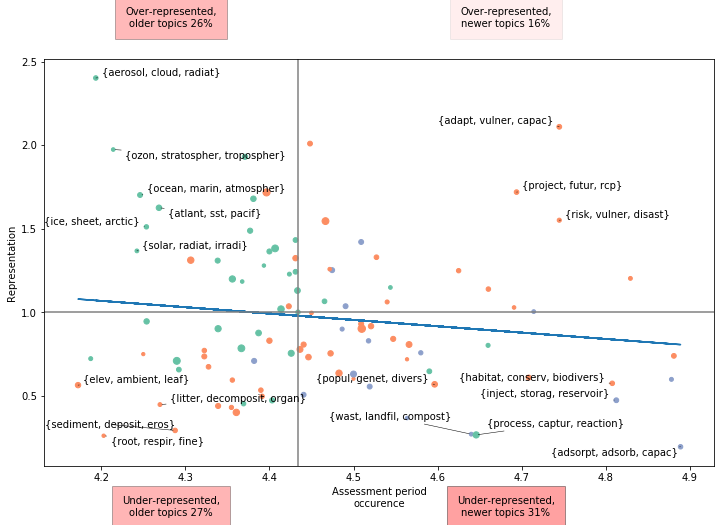

In [279]:
x = 'year_av'
y = 'representation'

fig, ax = plt.subplots()

cmap = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}
colors = [cmap[i] for i in mdf['primary_wg']]


mdf.plot.scatter(
    x,y,s=mdf['score']*0.03,
    c = colors,ax=ax
)

z = np.polyfit(x=mdf[x], y=mdf[y], deg=1)
p = np.poly1d(z)
mdf['trendline'] = p(mdf.loc[:, x])

plt.plot(mdf[x],mdf['trendline'])

qs = 5

mdf['x_q'] = pd.qcut(mdf[x], qs, labels=False)
mdf['y_q'] = pd.qcut(mdf[y], qs, labels=False)
texts = []


#for i, x in mdf[mdf['year_av']> 5.42].iterrows():
for i, row in mdf[(mdf['x_q'].isin([0,qs-1])) & (mdf['y_q'].isin([0,qs-1]))].iterrows():
    texts.append(plt.text(row[x],row[y],row['title'],ha='center', va='center'))
    
adjust_text(texts, 
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.axhline(1,c="grey")
plt.axvline(mdf[x].median(),c="grey")



# Put labels on the quadrants
# x
d1 = mdf[x].median()-plt.xlim()[0]
d2 = mdf[x].median()-plt.xlim()[1]

xlabpoints = [mdf[x].median()-d1/2,mdf[x].median()-d2/2]
labels = [
    ['Under-represented,\nolder topics','Under-represented,\nnewer topics'],
    ['Over-represented,\nolder topics','Over-represented,\nnewer topics']
]

pylims = plt.ylim()

tpad = (pylims[1]-pylims[0])*0.1




ops = [operator.lt,operator.gt]


for i in [0,1]:
    for j in [0,1]:
        if j==0:
            tpadx=tpad*-1
        else:
            tpadx=tpad
            
        q = mdf[(ops[i](mdf[x],mdf[x].median())) & (ops[j](mdf[y],1))]
        qshare = q['score'].sum()/mdf['score'].sum()
        plt.text(
            xlabpoints[i],
            pylims[j]+tpadx,
            labels[j][i] + " {:.0%}".format(qshare),
            va="center",ha="center",
            bbox={'facecolor':'red', 'alpha':qshare*2-0.25, 'pad':10}
        )

        

#ax.get_yaxis().set_visible(False)
#ax.tick_params(axis=u'both', which=u'both',length=0)
#ax2.tick_params(axis=u'both', which=u'both',length=0)
plt.xlabel('Assessment period\noccurence')
plt.ylabel('Representation')



plt.show()

In [194]:
plt.ylim()

(0.0, 1.0)

In [96]:
mdf.sort_values('x_q').head(15)

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,score,share,title,deviation,abs_md,representation,ys,year_av,x_q,y_q
49,0.061131,51.648320,0.006834,844.876951,1374.029876,0.017022,"{soil, moistur, microbi}",-0.010189,0.010189,0.401460,0.834072,5.000000,0,1
53,0.029822,6.996709,0.000926,234.618406,668.346077,0.004727,"{adsorpt, adsorb, capac}",-0.003801,0.003801,0.195844,0.936479,5.603960,0,7
66,0.072199,27.600853,0.003652,382.286562,767.100507,0.007702,"{inject, storag, reservoir}",-0.004050,0.004050,0.474147,0.899918,5.424242,0,7
38,0.039887,10.607514,0.001404,265.938777,385.865575,0.005358,"{root, respir, fine}",-0.003955,0.003955,0.261946,0.794505,4.772277,0,0
36,0.068267,22.749119,0.003010,333.236565,507.606884,0.006714,"{litter, decomposit, organ}",-0.003704,0.003704,0.448323,0.811761,4.887755,0,0
70,0.040632,24.862808,0.003290,611.903042,1298.677539,0.012328,"{process, captur, reaction}",-0.009039,0.009039,0.266838,0.897501,5.356436,0,7
54,0.041303,10.294637,0.001362,249.246622,492.612029,0.005022,"{wast, landfil, compost}",-0.003660,0.003660,0.271245,0.884874,5.320000,0,6
77,0.065664,24.891289,0.003293,379.072194,604.965663,0.007637,"{lake, diatom, level}",-0.004344,0.004344,0.431226,0.828234,4.980000,0,1
21,0.044705,20.371524,0.002695,455.684960,683.251724,0.009181,"{sediment, deposit, eros}",-0.006486,0.006486,0.293588,0.809603,4.870000,0,0
20,0.055964,12.374885,0.001637,221.122699,398.517460,0.004455,"{soc, stock, organ}",-0.002818,0.002818,0.367525,0.868293,5.210000,0,5


In [91]:
mdf[(mdf['x_q'].isin([1,qs])) & (mdf['y_q'].isin([1,qs]))]

,ipcc_coverage,ipcc_score,ipcc_share,ipcc_time_score,score,share,title,deviation,abs_md,representation,ys,year_av,x_q,y_q
4,0.087615,32.355501,0.004281,369.293359,693.927582,0.007440,"{habitat, conserv, biodivers}",-0.003159,0.003159,0.575382,0.892965,5.380000,1,1
18,0.072045,40.035741,0.005297,555.704594,890.632380,0.011196,"{fertil, nitrogen, treatment}",-0.005899,0.005899,0.473133,0.837570,5.019802,1,1
24,0.085966,49.460300,0.006544,575.349182,970.789572,0.011592,"{elev, ambient, leaf}",-0.005048,0.005048,0.564553,0.823803,4.940000,1,1
42,0.081374,33.679895,0.004456,413.889688,689.203199,0.008339,"{tree, stand, pine}",-0.003883,0.003883,0.534399,0.839905,5.050000,1,1
57,0.084656,36.189854,0.004788,427.491625,799.702578,0.008613,"{power, electr, generat}",-0.003825,0.003825,0.555954,0.871071,5.230000,1,1
65,0.075776,35.222940,0.004660,464.831184,665.965140,0.009365,"{site, differ, locat}",-0.004705,0.004705,0.497634,0.815880,4.890000,1,1
66,0.072199,27.600853,0.003652,382.286562,767.100507,0.007702,"{inject, storag, reservoir}",-0.004050,0.004050,0.474147,0.899918,5.424242,1,1
83,0.086713,53.416697,0.007068,616.019631,1064.938185,0.012411,"{popul, genet, divers}",-0.005344,0.005344,0.569458,0.867427,5.200000,1,1
88,0.077222,36.240126,0.004795,469.297763,785.360387,0.009455,"{fuel, fossil, engin}",-0.004660,0.004660,0.507132,0.849088,5.080000,1,1
96,0.069102,32.044747,0.004240,463.730145,685.882525,0.009343,"{delta, isotop, thousand}",-0.005103,0.005103,0.453807,0.815639,4.929293,1,1
